# Датасет

In [1]:
%matplotlib inline
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import os
from PIL import Image
import kagglehub
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from tqdm import tqdm
from tqdm.std import tqdm
import matplotlib
# matplotlib.use('TkAgg')
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc

class Brain_Dataset(Dataset):
    def __init__(self, train=True, transform=None):
        super().__init__()
        # path = kagglehub.dataset_download("navoneel/brain-mri-images-for-brain-tumor-detection")
        # self.img_dir = os.path.join(path, 'brain_tumor_dataset')
        self.img_dir = "C:\\Users\\user\\.cache\\kagglehub\\datasets\\navoneel\\brain-mri-images-for-brain-tumor-detection\\versions\\1\\brain_tumor_dataset"
        self.img_files = []
        for root, _, files in os.walk(self.img_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.img_files.append(os.path.join(root, file))

        split_int = int(len(self.img_files) * 0.8)
        indices = torch.randperm(len(self.img_files)).tolist()
        if train:
            self.img_files = [self.img_files[i] for i in indices[:split_int]]
        else:
            self.img_files = [self.img_files[i] for i in indices[split_int:]]

        self.labels = []
        for img_path in self.img_files:
            label = 1 if "yes" in os.path.basename(os.path.dirname(img_path)) else 0
            self.labels.append(label)

        self.transform = transform

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        img = Image.open(img_path).convert('L')

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return img, label

    @staticmethod
    def get_brain_loader(batch_size=64):
        transform_train = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5]),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.2)
        ])

        transform_test = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

        train_dataset = Brain_Dataset(train=True, transform=transform_train)
        test_dataset = Brain_Dataset(train=False, transform=transform_test)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        return train_loader, test_loader

C:\Users\user\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# CNN

In [3]:
class CNN_1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 1)

        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.batchnorm_fc = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(torch.relu(self.batchnorm2(self.conv2(x))))
        x = self.pool(torch.relu(self.batchnorm3(self.conv3(x))))
        x = x.view(-1, 64 * 28 * 28)
        x = torch.relu(self.batchnorm_fc(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


class CNN_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 1)

        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.batchnorm_fc = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(torch.relu(self.batchnorm2(self.conv2(x))))
        x = self.pool(torch.relu(self.batchnorm3(self.conv3(x))))
        x = x.view(-1, 128 * 28 * 28)
        x = torch.relu(self.batchnorm_fc(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Обучение 

In [5]:
def run_epoch(model, data_loader, criterion, optimizer=None, device='cpu', is_test=False):
    if is_test:
        model.eval()
    else:
        model.train()

    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(tqdm(data_loader)):
        data, target = data.to(device), target.to(device).unsqueeze(1)

        if optimizer is not None:
            optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, target)

        if not is_test and optimizer is not None:
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        pred = (output > 0.5).float()
        correct += pred.eq(target).sum().item()
        total += target.size(0)

    return total_loss / len(data_loader), correct / total


def train_model(model, train_loader, test_loader, epochs=10, lr=0.001, device='cpu'):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, train_accs = [], []
    test_losses, test_accs = [], []

    for epoch in range(epochs):
        train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer, device, is_test=False)
        test_loss, test_acc = run_epoch(model, test_loader, criterion, None, device, is_test=True)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f'Epoch {epoch + 1}/{epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
        print('-' * 50)

    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs
    }


# Для визуализации 

In [7]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(history['train_losses'], label='Train Loss')
    ax1.plot(history['test_losses'], label='Test Loss')
    ax1.set_title('Loss')
    ax1.legend()
    ax2.plot(history['train_accs'], label='Train Acc')
    ax2.plot(history['test_accs'], label='Test Acc')
    ax2.set_title('Accuracy')
    ax2.legend()
    plt.tight_layout()
    plt.show()


def compute_confusion_matrix(model, data_loader, device='cpu'):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            preds = (output > 0.5).float().cpu().numpy()
            all_preds.extend(preds)
            all_targets.extend(target.cpu().numpy())

    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
def visualize_first_layer_activations(model, data_loader, device, title="Model"):
    model.eval()
    data, _ = next(iter(data_loader))
    data = data.to(device)

    first_conv_layer = None
    for layer in model.children():
        if isinstance(layer, nn.Conv2d):
            first_conv_layer = layer
            break

    if first_conv_layer is None:
        print("Нет сверточных слоев в модели.")
        return

    with torch.no_grad():
        activations = first_conv_layer(data)

    img = data[0].cpu().numpy().transpose((1, 2, 0))
    img = (img - img.min()) / (img.max() - img.min())

    fig, axes = plt.subplots(1, activations.size(1) + 1, figsize=(15, 3))
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    for i in range(activations.size(1)):
        act = activations[0, i].cpu().numpy()
        act = (act - act.min()) / (act.max() - act.min())
        axes[i + 1].imshow(act, cmap='viridis')
        axes[i + 1].set_title(f'Ch {i + 1}')
        axes[i + 1].axis('off')

    plt.suptitle(f"{title} - First Layer Activations")
    plt.tight_layout()
    plt.show()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [8]:
def plot_roc_curve(model, data_loader, device='cpu'):
    model.eval()
    all_probs = []
    all_targets = []
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = torch.sigmoid(model(data))
            all_probs.extend(output.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    fpr, tpr, _ = roc_curve(all_targets, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(history['train_losses'], label='Train Loss', marker='o')
    ax1.plot(history['test_losses'], label='Test Loss', marker='x')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)
    ax1.legend()

    ax2.plot(history['train_accs'], label='Train Acc', marker='o')
    ax2.plot(history['test_accs'], label='Test Acc', marker='x')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()



# Запуск

Количество параметров 16x32x64: 25715681


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 1/20:
Train Loss: 0.6312, Train Acc: 0.5842
Test Loss: 0.6663, Test Acc: 0.4706
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.71s/it]


Epoch 2/20:
Train Loss: 0.4735, Train Acc: 0.7327
Test Loss: 0.6622, Test Acc: 0.4706
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


Epoch 3/20:
Train Loss: 0.3531, Train Acc: 0.8119
Test Loss: 0.6369, Test Acc: 0.4706
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


Epoch 4/20:
Train Loss: 0.3087, Train Acc: 0.8218
Test Loss: 0.6058, Test Acc: 0.4902
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]


Epoch 5/20:
Train Loss: 0.3058, Train Acc: 0.8416
Test Loss: 0.5633, Test Acc: 0.5490
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


Epoch 6/20:
Train Loss: 0.2585, Train Acc: 0.9059
Test Loss: 0.5150, Test Acc: 0.6078
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


Epoch 7/20:
Train Loss: 0.2150, Train Acc: 0.9356
Test Loss: 0.4630, Test Acc: 0.8235
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


Epoch 8/20:
Train Loss: 0.2113, Train Acc: 0.9505
Test Loss: 0.4704, Test Acc: 0.8824
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


Epoch 9/20:
Train Loss: 0.2046, Train Acc: 0.9109
Test Loss: 0.5079, Test Acc: 0.7843
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


Epoch 10/20:
Train Loss: 0.3111, Train Acc: 0.9455
Test Loss: 0.4040, Test Acc: 0.9020
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


Epoch 11/20:
Train Loss: 0.1364, Train Acc: 0.9554
Test Loss: 0.3348, Test Acc: 0.8824
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


Epoch 12/20:
Train Loss: 0.1731, Train Acc: 0.9703
Test Loss: 0.3070, Test Acc: 0.8824
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.73s/it]


Epoch 13/20:
Train Loss: 0.1342, Train Acc: 0.9752
Test Loss: 0.2762, Test Acc: 0.8627
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.68s/it]


Epoch 14/20:
Train Loss: 0.1185, Train Acc: 0.9851
Test Loss: 0.3191, Test Acc: 0.8627
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 15/20:
Train Loss: 0.1128, Train Acc: 0.9950
Test Loss: 0.4089, Test Acc: 0.8431
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.88s/it]


Epoch 16/20:
Train Loss: 0.1045, Train Acc: 0.9950
Test Loss: 0.4256, Test Acc: 0.8431
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.84s/it]


Epoch 17/20:
Train Loss: 0.0987, Train Acc: 0.9901
Test Loss: 0.3264, Test Acc: 0.8824
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 18/20:
Train Loss: 0.0786, Train Acc: 0.9901
Test Loss: 0.2649, Test Acc: 0.8627
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.63s/it]


Epoch 19/20:
Train Loss: 0.1397, Train Acc: 0.9752
Test Loss: 0.2611, Test Acc: 0.8627
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


Epoch 20/20:
Train Loss: 0.2108, Train Acc: 0.9802
Test Loss: 0.2881, Test Acc: 0.9020
--------------------------------------------------


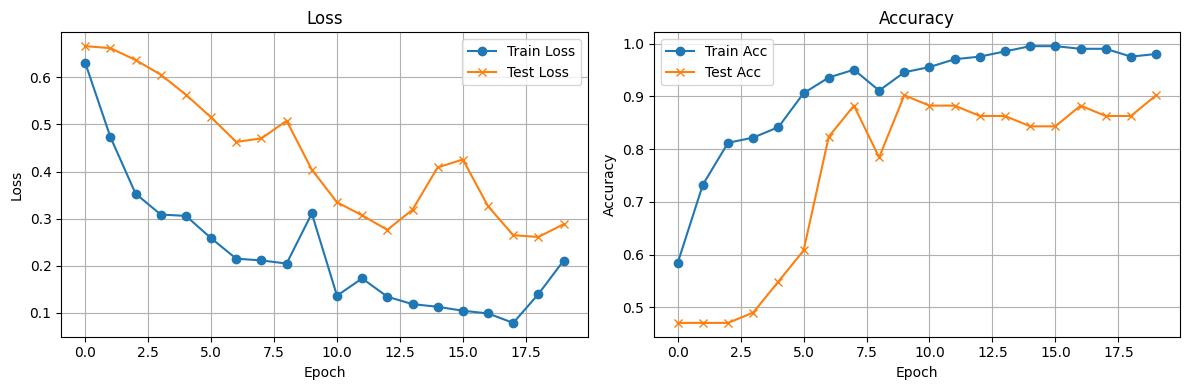

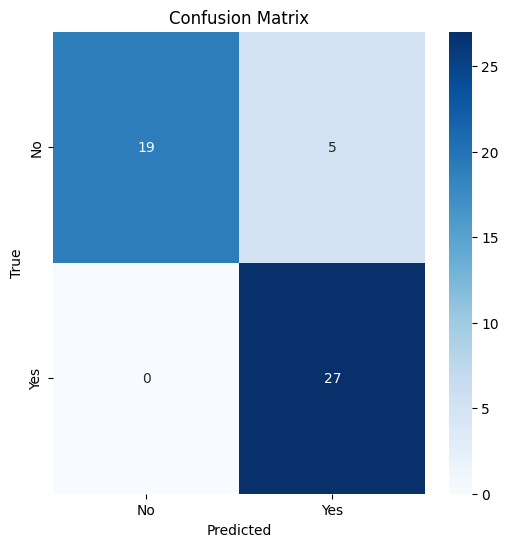

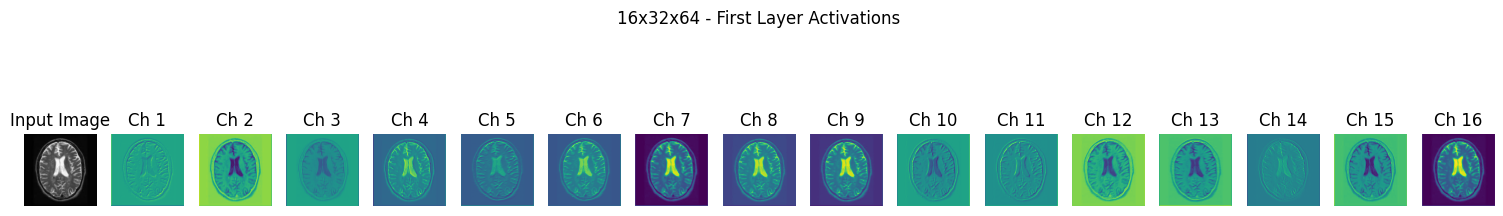

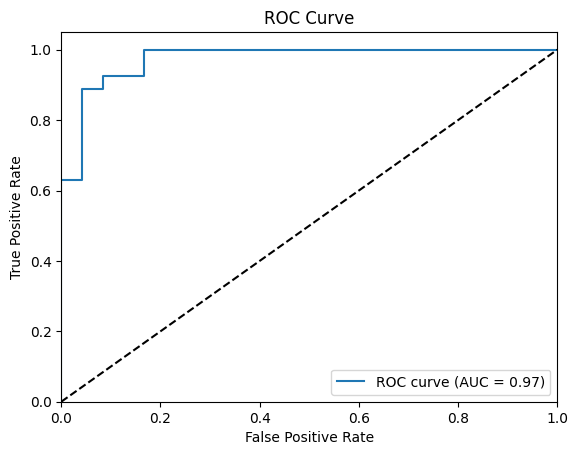

Количество параметров 32x64x128: 51475393


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.93s/it]


Epoch 1/20:
Train Loss: 0.8117, Train Acc: 0.5347
Test Loss: 0.7655, Test Acc: 0.4706
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  3.00s/it]


Epoch 2/20:
Train Loss: 0.5067, Train Acc: 0.7228
Test Loss: 0.6855, Test Acc: 0.4706
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  3.00s/it]


Epoch 3/20:
Train Loss: 0.4546, Train Acc: 0.7228
Test Loss: 0.6553, Test Acc: 0.4706
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.00s/it]


Epoch 4/20:
Train Loss: 0.3757, Train Acc: 0.7475
Test Loss: 0.6341, Test Acc: 0.4902
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.17s/it]


Epoch 5/20:
Train Loss: 0.3936, Train Acc: 0.7970
Test Loss: 0.6022, Test Acc: 0.5686
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.36s/it]


Epoch 6/20:
Train Loss: 0.3264, Train Acc: 0.8267
Test Loss: 0.5609, Test Acc: 0.6275
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.47s/it]


Epoch 7/20:
Train Loss: 0.2694, Train Acc: 0.8960
Test Loss: 0.5363, Test Acc: 0.7059
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.38s/it]


Epoch 8/20:
Train Loss: 0.3387, Train Acc: 0.8960
Test Loss: 0.5222, Test Acc: 0.6275
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.45s/it]


Epoch 9/20:
Train Loss: 0.2757, Train Acc: 0.9208
Test Loss: 0.4919, Test Acc: 0.6863
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.18s/it]


Epoch 10/20:
Train Loss: 0.2045, Train Acc: 0.9307
Test Loss: 0.5067, Test Acc: 0.9020
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.19s/it]


Epoch 11/20:
Train Loss: 0.1997, Train Acc: 0.9505
Test Loss: 0.5481, Test Acc: 0.8039
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.01s/it]


Epoch 12/20:
Train Loss: 0.1679, Train Acc: 0.9653
Test Loss: 0.5250, Test Acc: 0.8431
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.96s/it]


Epoch 13/20:
Train Loss: 0.1675, Train Acc: 0.9802
Test Loss: 0.5476, Test Acc: 0.7843
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.96s/it]


Epoch 14/20:
Train Loss: 0.1368, Train Acc: 0.9406
Test Loss: 0.7801, Test Acc: 0.6078
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.96s/it]


Epoch 15/20:
Train Loss: 0.1385, Train Acc: 0.9554
Test Loss: 0.5076, Test Acc: 0.8235
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.90s/it]


Epoch 16/20:
Train Loss: 0.0945, Train Acc: 0.9851
Test Loss: 0.5407, Test Acc: 0.8235
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.93s/it]


Epoch 17/20:
Train Loss: 0.0859, Train Acc: 0.9653
Test Loss: 0.6046, Test Acc: 0.8039
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.89s/it]


Epoch 18/20:
Train Loss: 0.0801, Train Acc: 0.9851
Test Loss: 0.5782, Test Acc: 0.8235
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.25s/it]


Epoch 19/20:
Train Loss: 0.0624, Train Acc: 0.9851
Test Loss: 0.3132, Test Acc: 0.8824
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.43s/it]


Epoch 20/20:
Train Loss: 0.0703, Train Acc: 0.9950
Test Loss: 0.2393, Test Acc: 0.9216
--------------------------------------------------


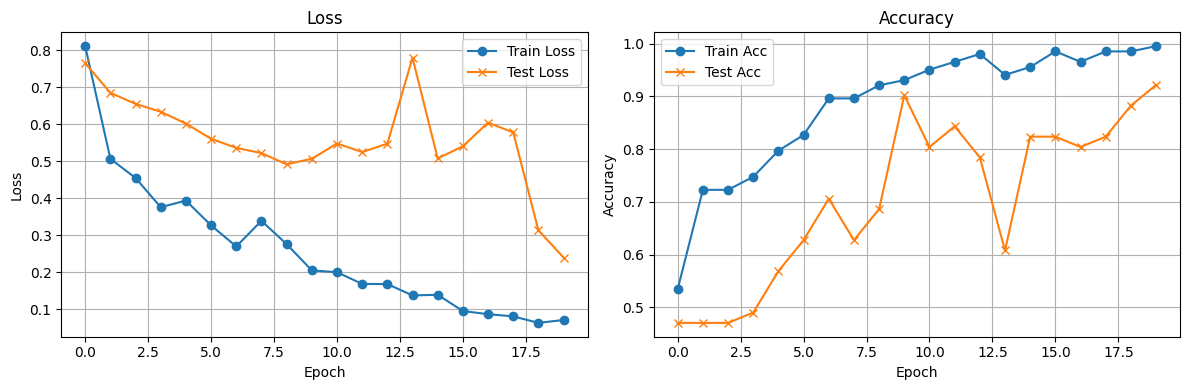

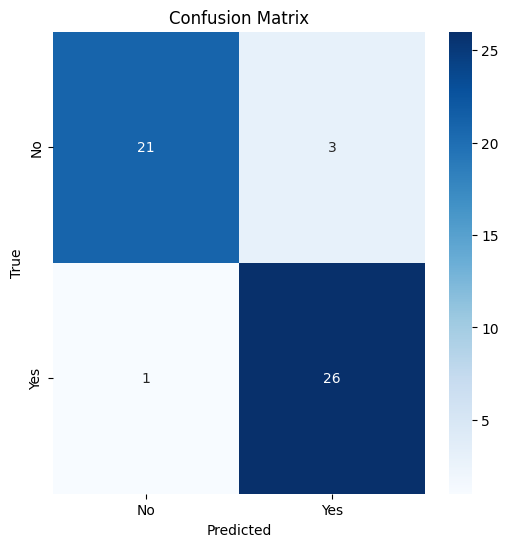

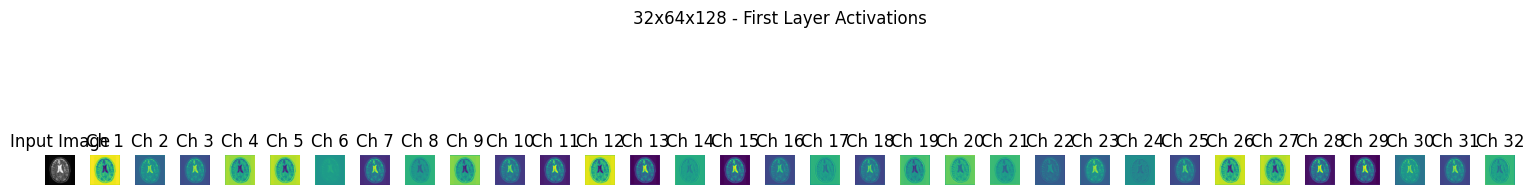

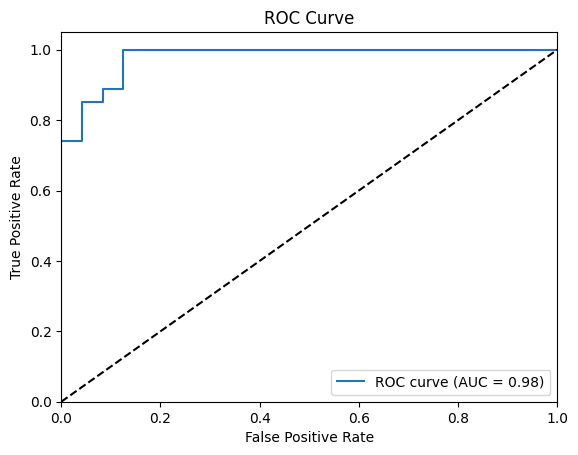

In [25]:
import time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loader, test_loader = Brain_Dataset.get_brain_loader(batch_size=64)
EPOCHS = 20

CNN_cores = {
    '16x32x64': CNN_1().to(device),
    '32x64x128': CNN_2().to(device)
}
# CNN_cores = {
#     '16x32x64': CNN_1().to(device),
# }

results = {}

for name, model in CNN_cores.items():
    print(f"Количество параметров {name}: {count_parameters(model)}")
    start_time = time.time()
    history = train_model(model, train_loader, test_loader, epochs=EPOCHS, lr=0.0001, device=device)
    end_time = time.time()

    results[name] = {
        'time train': end_time - start_time,
        'history': history
    }
    plot_training_history(history)
    compute_confusion_matrix(model, test_loader, device=device)
    visualize_first_layer_activations(model, test_loader, device, title=name)
    plot_roc_curve(model, test_loader, device=device)
    torch.save(model.state_dict(), f"{name}_model.pth")



Тест модели


Тестирую изображение: D:\УЧЕБА_УРФУ\Программирование\4_семестр\Практика\img_test\2.jpg
Предсказание: Опухоль, Вероятность наличия опухоли: 0.9891


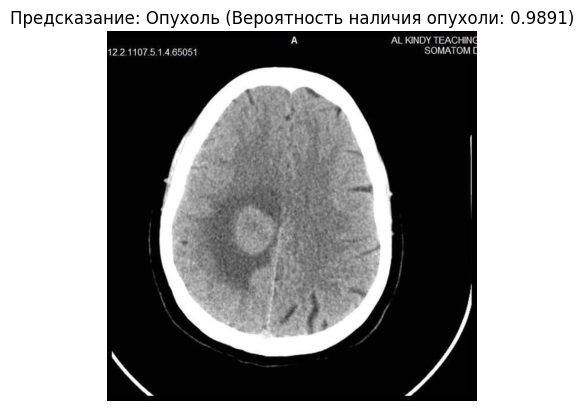


Тестирую изображение: D:\УЧЕБА_УРФУ\Программирование\4_семестр\Практика\img_test\3.jpg
Предсказание: Без опухоли, Вероятность наличия опухоли: 0.0949


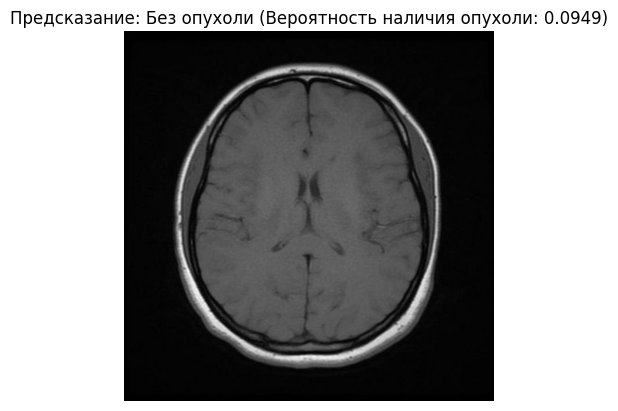


Тестирую изображение: D:\УЧЕБА_УРФУ\Программирование\4_семестр\Практика\img_test\4.jpg
Предсказание: Опухоль, Вероятность наличия опухоли: 0.8607


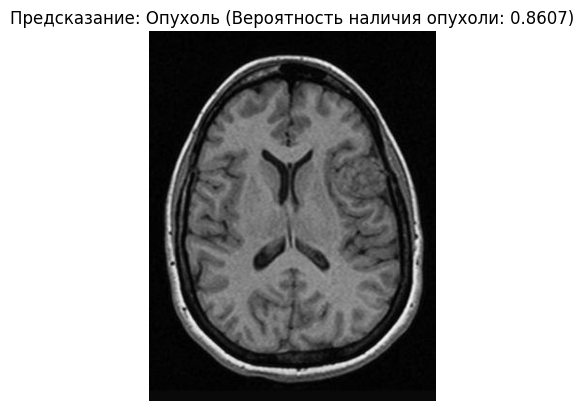


Тестирую изображение: D:\УЧЕБА_УРФУ\Программирование\4_семестр\Практика\img_test\5.jpg
Предсказание: Опухоль, Вероятность наличия опухоли: 0.9698


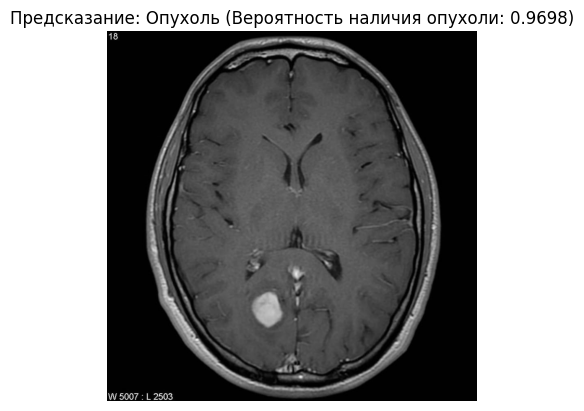


Тестирую изображение: D:\УЧЕБА_УРФУ\Программирование\4_семестр\Практика\img_test\6.jpg
Предсказание: Без опухоли, Вероятность наличия опухоли: 0.1322


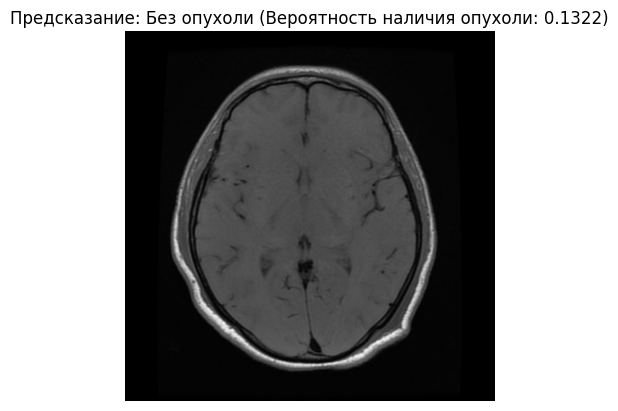

In [30]:
def predict_image(model, image_path, transform, device='cpu'):
    model.eval()
    try:
        img = Image.open(image_path).convert('L')
    except Exception as e:
        print(f"Ошибка при открытии изображения: {e}")
        return None, None

    img_t = transform(img).unsqueeze(0).to(device)  # добавляем batch dimension
    with torch.no_grad():
        output = torch.sigmoid(model(img_t))
        prob = output.item()
        pred = "Опухоль" if prob > 0.5 else "Без опухоли"

    return pred, prob


def visualize_prediction(image_path, prediction, probability):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(f"Предсказание: {prediction} (Вероятность наличия опухоли: {probability:.4f})")
    plt.axis('off')
    plt.show()


if __name__ == "__main__":
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_path = "D:\\УЧЕБА_УРФУ\\Программирование\\4_семестр\\Практика\\16x32x64_model.pth"

    model = CNN_1().to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    test_images = [
        "D:\\УЧЕБА_УРФУ\\Программирование\\4_семестр\\Практика\\img_test\\2.jpg",
        "D:\\УЧЕБА_УРФУ\\Программирование\\4_семестр\\Практика\\img_test\\3.jpg",
        "D:\\УЧЕБА_УРФУ\\Программирование\\4_семестр\\Практика\\img_test\\4.jpg",
        "D:\\УЧЕБА_УРФУ\\Программирование\\4_семестр\\Практика\\img_test\\5.jpg",
        "D:\\УЧЕБА_УРФУ\\Программирование\\4_семестр\\Практика\\img_test\\6.jpg"
    ]

    for image_path in test_images:
        print(f"\nТестирую изображение: {image_path}")
        prediction, probability = predict_image(model, image_path, transform_test, device=device)
        print(f"Предсказание: {prediction}, Вероятность наличия опухоли: {probability:.4f}")
        visualize_prediction(image_path, prediction, probability)